# Classification

## Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import os
import sys
import time
import joblib

# Add ../src to Python path
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../src'))
sys.path.insert(0, project_root)

# Import the parse config function to parse the .toml file
from utils.config_tool import parse_config
from engine.clean import clean_All_news as cc

def notify(title, text):
    os.system("""
              osascript -e 'display notification "{}" with title "{}"'
              """.format(text, title))


In [3]:
# Load the config file
config_file = "../config/predict_stock_w_news.toml"
config = parse_config(config_file)


In [4]:

# The load path and save path
load_path = os.path.join(config['info']['local_data_path'],'data_raw', config['news_ingestion']['input']["news_head_line"])
save_path = os.path.join(config['info']['local_data_path'],'data_clean', config['news_preprocessing']['output']["news_head_line_cleaned"])


In [ ]:

# Load the raw data
df = pd.read_json(load_path, lines=True)

df.head()

## Preprocessing

In [ ]:
# Drop the duplicated rows which is not null
cleaned = pd.concat([df[(df['headline'] != '') & (df['short_description'] != '')].drop_duplicates(subset=['headline', 'short_description']), df[(df['headline'] == '') | (df['short_description'] == '')]])

# Combine the headline and the summary
cleaned['headline_summary'] = cleaned['headline'] + ' ' + cleaned['short_description']

# Drop the original headline and summary and the columns that are not needed
cleaned.drop(columns=['headline', 'short_description', 'authors', 'link', 'date'], inplace=True)

# Drop the rows with missing values
headline = cleaned[cleaned['headline_summary'] != '']

In [ ]:
headline.head()

In [ ]:
headline[headline['headline_summary'].duplicated()]

In [ ]:
# Drop the duplicated rows

headline.drop_duplicates(subset=['headline_summary'], inplace=True)

In [ ]:
headline[headline['headline_summary'].duplicated()]

In [ ]:
# Add the tokenized headline and summary
headline['headline_summary_tokenized'] = headline['headline_summary'].apply(cc.get_tokenized_words_with_no_punctuation)
# remove the stop words and lemmatize the words
headline['headline_summary_tokenized'] = headline['headline_summary_tokenized'].apply(cc.remove_stop_words)
headline['headline_summary_tokenized'] = headline['headline_summary_tokenized'].apply(cc.lemmatize_words)
# Drop the orginal headline and summary
headline.drop(columns=['headline_summary'], inplace=True)
# NER
headline = pd.concat([headline, headline['headline_summary_tokenized'].apply(lambda x : cc.extract_ner_features(''.join(x)))], axis=1)

In [ ]:
# Remove the rows with less than 10 words
headline = headline[headline['headline_summary_tokenized'].apply(lambda x : len(x)) >= 10]

# Save the cleaned data
headline.to_csv(save_path, index=False)


In [5]:
# Reload the cleaned data

headline = pd.read_csv(save_path)
headline.head()

,category,headline_summary_tokenized,PERSON,ORG,GPE,EVENT,PRODUCT
0,U.S. NEWS,"['4', 'million', 'american', 'roll', 'sleeve',...",0,0,0,0,0
1,U.S. NEWS,"['american', 'airline', 'flyer', 'charged', 'b...",0,0,0,0,0
2,COMEDY,"['23', 'funniest', 'tweet', 'cat', 'dog', 'wee...",0,0,0,0,0
3,PARENTING,"['funniest', 'tweet', 'parent', 'week', 'accid...",0,0,0,0,0
4,U.S. NEWS,"['woman', 'called', 'cop', 'black', 'loses', '...",0,0,0,0,0


In [6]:

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

stop = headline['headline_summary_tokenized'].apply(lambda tokens: tokens in stop_words)
print(stop.astype(int).sum())
null = headline['headline_summary_tokenized'].apply(lambda tokens: tokens == [])
print(null.astype(int).sum())
lenth = headline['headline_summary_tokenized'].apply(lambda tokens: len(tokens))
print(lenth.describe())

0
0
count    178064.000000
mean        185.469281
std          63.379008
min          72.000000
25%         142.000000
50%         177.000000
75%         216.000000
max        1402.000000
Name: headline_summary_tokenized, dtype: float64


## Sample data:

Since the the category is not evenly distributed, we need to find a training set which samples 10000 elements from each category.

In [7]:
# Set the category we want to predict
categorys_to_predict = ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'ELSE']

# Rename the category
headline['category'] = headline['category'].apply(lambda x: x if x in categorys_to_predict else 'ELSE')

In [8]:
headline['category'].value_counts()

category
ELSE             116515
POLITICS          30775
WELLNESS          17854
ENTERTAINMENT     12920
Name: count, dtype: int64

In [9]:
# Sampling the data
sameple_size = 10000
sampled = headline.groupby('category').apply(lambda x: x.sample(sameple_size, random_state=42))

/var/folders/l_/txq0vh11623_5lrnfw_cpmsh0000gn/T/ipykernel_3591/3779012536.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = headline.groupby('category').apply(lambda x: x.sample(sameple_size, random_state=42))


In [10]:
sampled['category'].value_counts()

category
ELSE             10000
ENTERTAINMENT    10000
POLITICS         10000
WELLNESS         10000
Name: count, dtype: int64

## TF-IDF embedding

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Choose the words that appear in at least 5 documents and at most 50% of the documents
tfidf = TfidfVectorizer(max_df=0.5, min_df=5)
tfidf_matrix = tfidf.fit_transform(sampled['headline_summary_tokenized'])

In [ ]:
# After I fit the tfidf, I can transform the new data
diff = 0

for i in range(len(sampled)):
    a1 = tfidf.transform([sampled['headline_summary_tokenized'][i]]).toarray()
    a2 = tfidf_matrix[i].toarray()
    # If the error is larger than 1e-15, print the index, otherwise, the error is due to the floating point precision
    if np.abs(a1-a2).max() >= 1e-15:
        print(i)
        diff += np.abs(a1-a2).sum()


print(diff)

In [ ]:
# Save the tfidf


tfidf_path = os.path.join(config['info']['local_data_path'], 'model_news', config['news_model']['input']['tfidf_headline'])


joblib.dump(tfidf, tfidf_path) 

Best practice: Use `tfidf_matrix` to maintain consistency with original transformation.

It records the original data information. For new data, we simply use `tfidf.transform`.

## Nonnegative matrix factorization

When consider the Tfidf matrix, each coefficient is nonnegative. And when the number of tokens are large, the matrix is very sparse. So instead of using PCA, it is better to consider the nonnegative matrix factorization (NMF).

In [12]:
from sklearn.decomposition import NMF

In [ ]:
# Find the best number of components
#! Warning: It takes a long time to run

start = time.time()
n_components = [100, 200, 300, 400, 500]
rss = []
t0 = start
for n in n_components:
    nmf = NMF(n_components=n, max_iter=500)
    E_matrix = nmf.fit_transform(tfidf_matrix)
    print(f"To process {n} components, it takes {time.time()-t0} seconds")
    t0 = time.time()
    rss.append(nmf.reconstruction_err_)

duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

In [ ]:
# # Compute Residual Sum of Squares (RSS) for Non-Negative Matrix Factorization (NMF)
# rss = np.sum(np.square(tfidf_matrix - E_matrix @ nmf.components_))
# rss1 = nmf.reconstruction_err_
# print(rss, rss1**2)

print(f"The rss is {rss}")
print(f"The best number of components is {n_components[np.argmin(rss)]}")

To find the best number of compoenets. Note that the time I run:
``` python
import time
start = time.time()
n_components = [100, 200, 300, 400, 500]
rss = []
t0 = start
for n in n_components:
    nmf = NMF(n_components=n, max_iter=500)
    E_matrix = nmf.fit_transform(tfidf_matrix)
    print(f"To process {n} components, it takes {time.time()-t0} seconds")
    t0 = time.time()
    rss.append(nmf.reconstruction_err_)
```

**The output:**
``` zsh
To process 100 components, it takes 52.489633083343506 seconds
To process 200 components, it takes 256.3671808242798 seconds
To process 300 components, it takes 2259.08752989769 seconds
To process 400 components, it takes 6990.929425239563 seconds
To process 500 components, it takes 7964.212979078293 seconds
```

And the residual sum of squares (reconstruction error):
``` python
print(f"The rss is {rss}")
print(f"The best number of components is {n_components[np.argmin(rss)]}")
```

**The output:**
``` zsh
The rss is [np.float64(188.4237102845113), np.float64(181.7639160482998), np.float64(176.32832738298404), np.float64(171.49108989213317), np.float64(167.21638211672698)]
The best number of components is 500
```
The whole procedure will take ~ 10 hours, so we do not want to run this again.

It turns out that the more components we want to get, the longer time will be needed. Of course it will decrease the error, but not significantly. To balance this, keep 500 componenets will need ~ 2 hours, which is acceptable. So it is better to work on 100 and 200 componenets first, and if it performs bad, we may need to increase the components.

In [ ]:
# Lets keep 200 compon_components = 200

nmf = NMF(n_components=200, max_iter=500)
E_matrix = nmf.fit_transform(tfidf_matrix)
error = nmf.reconstruction_err_

In [ ]:
# Save the model

nmf_model_path = os.path.join(config['info']['local_data_path'], 'model_news', config['news_model']['input']['tfidf_nmf_headline'])

joblib.dump(nmf, nmf_model_path)


In [ ]:
# Reload the model
tfidf1 = joblib.load(tfidf_path)
nmf1 = joblib.load(nmf_model_path)
print(error, nmf1.reconstruction_err_)
# Get the E matrix
E_matrix1 = nmf1.transform(tfidf1.transform(sampled['headline_summary_tokenized']))
print(np.abs(E_matrix-E_matrix1).max())
print(E_matrix1.shape, E_matrix.shape)


The small difference (0.00086) between E_matrix and E_matrix1 occurs because:

- Floating point precision limitations
- NMF transformation is not exactly deterministic
- Multiple matrix operations compound small differences

The matrices are effectively identical since:

- Max difference is ~0.00086 (less than 0.1%)
- Shapes match exactly (40000, 200)
- Reconstruction errors are identical (181.79)

## Use Word2Vec embedding method

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# Need to define the class for the word2vec
# Word2Vec doesn't have fit_transform like sklearn, so we need to define the class to fit_transform

class Word2VecVectorizer:
    """ We need to define the class for the word2vec so that we can do fit_transform like sklearn
    """

    """" Word2VecVectorized does not support workers < 1, so we set the default workers to 4 """
    def __init__(self, vector_size=200, window=5, min_count=1, workers=4):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.word2vec = None
    
    
    def fit_transform(self, X):
        self.word2vec = Word2Vec(X, vector_size=self.vector_size, window=self.window, min_count=self.min_count, workers=self.workers)
        return np.vstack([np.mean([self.word2vec.wv[word] for word in doc if word in self.word2vec.wv], axis=0) for doc in X])
    
    def transform(self, X):
        if self.word2vec is None:
            raise ValueError("The model is not fitted")
        return np.vstack([np.mean([self.word2vec.wv[word] for word in doc if word in self.word2vec.wv], axis=0) for doc in X])

In [ ]:
# Fit the word2vec model

word2vec = Word2VecVectorizer()
word2vec_matrix = word2vec.fit_transform(sampled['headline_summary_tokenized'])
print(word2vec_matrix.shape)

duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("The preprocessing is done", "The preprocessing is done")

In [ ]:
# Save the word2vec model

word2vec_path = os.path.join(config['info']['local_data_path'], 'model_news', config['news_model']['input']['word2vec_headline'])

joblib.dump(word2vec, word2vec_path)

## Metrics to measure the performance

In [84]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

def get_accuracy(y_true, y_pred):
    lables = ['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS']
    confusion = confusion_matrix(y_true, y_pred,labels = lables)
    print(f"The accuracy is {accuracy_score(y_true, y_pred)}")
    print(f"The confusion matrix \n{lables} is \n{confusion}")

    # Map 'ELSE' to 0 (negative) and others to 1 (positive)
    y_test_binary = [0 if label == 'ELSE' else 1 for label in y_true]
    y_pred_binary = [0 if label == 'ELSE' else 1 for label in y_pred]

    # Compute the F1 score (treating 1 as the positive class)
    f1 = f1_score(y_test_binary, y_pred_binary, pos_label=1, average='binary')
    print(f"F1 Score when we treat ELSE as negative: {f1}")
    f1_seperate = f1_score(y_true, y_pred, pos_label=1, average=None)
    print(f"F1 Score for everclass: \n{lables} \n{f1_seperate}")

In [14]:
def get_misclassified_samples(y_test, y_pred):
    misclassified_idx = np.where(y_test != y_pred)[0]
    sampled_test = sampled.loc[y_test.index]
    results = {'index': misclassified_idx, 'true': y_test[misclassified_idx], 'pred': y_pred[misclassified_idx], 'headline': sampled_test['headline_summary_tokenized'].iloc[misclassified_idx].apply(lambda x: ' '.join(x))}
    return pd.DataFrame(results)

In [15]:
# Initialte a dataframe to store the misclassified index of each model
misclassified = pd.DataFrame()

## Supervised learning classification

In [16]:
# import train test split and kfold
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.preprocessing import LabelEncoder

### Load the pre-saved features

In [17]:
tfidf_path = os.path.join(config['info']['local_data_path'], 'model_news', config['news_model']['input']['tfidf_headline'])
nmf_model_path = os.path.join(config['info']['local_data_path'], 'model_news', config['news_model']['input']['tfidf_nmf_headline'])


# Load the features using joblib

tfidf = joblib.load(tfidf_path)
nmf = joblib.load(nmf_model_path)
#word2vec = joblib.load(word2vec_path)

# Transform the data
transformed_data = nmf.transform(tfidf.transform(sampled['headline_summary_tokenized']))

# Transform the data using word2vec
#transformed_data = word2vec.transform(sampled['headline_summary_tokenized'])

For the standard machine learning algorithms, we choose Tf-idf embedding. It will out perform the word2vec embedding a lot. 

Later, when we try to do the neural network, we can try word2vec.

In [18]:
# Split the data into training and testing

X_train, X_test, y_train, y_test = train_test_split(transformed_data, sampled['category'], test_size=0.2, stratify=sampled['category'], random_state=42)

### 1: KNN

In [19]:
# import the knn model
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Train the model, choose the best number of neighbors using cross validation

kfold = StratifiedKFold(n_splits=5, random_state =42, shuffle=True)

i=0
ks = range(1, 1000)
accs=np.zeros((5, len(ks)))

for train_index, test_index in kfold.split(X_train, y_train):
    X_tt, X_ho = X_train[train_index], X_train[test_index]
    y_tt, y_ho = y_train.iloc[train_index], y_train.iloc[test_index]

    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_tt, y_tt)
        accs[i, k-1] = accuracy_score(y_ho, knn.predict(X_ho))
    i += 1

duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("KNN", "KNN has finished training")


In [ ]:
# Find the best number of neighbors
accs_mean = accs.mean(axis=0)
best_k = ks[np.argmax(accs_mean)]

print(f"The best number of neighbors is {best_k}")
notify("KNN", f"The best number of neighbors is {best_k}")

The optimal k is ~70.

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(ks, accs_mean)

plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN: Accuracy vs Number of Neighbors')

plt.show()

In [ ]:
# Final output
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
get_accuracy(y_test, y_pred)

In [ ]:
# Use the grid search to find the best parameters for the KNN model

param_grid = {'n_neighbors': range(1, 1000)}
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"The best parameters are {grid_search.best_params_}")

duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("KNN", f"The best parameters are {grid_search.best_params_}")

The best parameters are {'n_neighbors': 38}

In [20]:
# The best parameter:

#best_k = grid_search.best_params_['n_neighbors']
best_k=38

knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)
get_accuracy(y_test, y_pred)
mis_KNN = get_misclassified_samples(y_test, y_pred)

The accuracy is 0.5405
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[ 977  588  161  274]
 [ 447 1246  147  160]
 [ 466  302 1099  133]
 [ 569  377   52 1002]]
F1 Score when we treat ELSE as negative: 0.7829477514946712
F1 Score for everclass: 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] 
[0.43821485 0.55218258 0.63544377 0.56150182]


/var/folders/l_/txq0vh11623_5lrnfw_cpmsh0000gn/T/ipykernel_3591/2370515181.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = {'index': misclassified_idx, 'true': y_test[misclassified_idx], 'pred': y_pred[misclassified_idx], 'headline': sampled_test['headline_summary_tokenized'].iloc[misclassified_idx].apply(lambda x: ' '.join(x))}


In [21]:
mis_KNN.rename(columns={'index': 'index_KNN'}, inplace=True)

misclassified = pd.concat([misclassified, mis_KNN['index_KNN']], axis=1)

### 2: SVM

In [22]:
# import svm model
from sklearn.svm import SVC

In [ ]:
# Train the model, find the best hyperparameters using cross validation 1:

kfold = StratifiedKFold(n_splits=5, random_state =42, shuffle=True)
Cs = [0.1, 1, 10, 100, 1000]
#kernels = ['linear', 'poly', 'rbf', 'sigmoid']
degrees = range(1, 10)

i=0
start = time.time()
t0 = time.time()
accs_svc_poly = np.zeros((5, len(Cs), len(degrees)))

for train_index, test_index in kfold.split(X_train, y_train):
    X_tt, X_ho = X_train[train_index], X_train[test_index]
    y_tt, y_ho = y_train.iloc[train_index], y_train.iloc[test_index]

    for c in Cs:
        for d in degrees:
            print(f"start to process {c} and {d} in the {i+1}th fold")
            svc = SVC(C=c, kernel='poly', degree=d)
            svc.fit(X_tt, y_tt)
            accs_svc_poly[i, Cs.index(c), degrees.index(d)] = accuracy_score(y_ho, svc.predict(X_ho))
            print(f"To process {c} and {d} in the {i+1}th fold, it takes {time.time()-t0} seconds")
            t0 = time.time()
    i += 1

duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("SVM", "SVM has finished training")


In [ ]:
accs_svc_poly_mean = accs_svc_poly.mean(axis=0)
best_c, best_d = np.unravel_index(np.argmax(accs_svc_poly_mean), accs_svc_poly_mean.shape)
print(f"The best C is {Cs[best_c]} and the best degree is {degrees[best_d]}")
notify("SVM", f"The best C is {Cs[best_c]} and the best degree is {degrees[best_d]}")

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(Cs, accs_svc_poly_mean[:, best_d])

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('SVM: Accuracy vs C')

plt.show()

Seems like when C is getting larger, the accuracy is getting better. A good trade-off is C=100.

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(degrees, accs_svc_poly_mean[best_c])

plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.title('SVM: Accuracy vs Degree')

plt.show()

Seems like when the degree of the polynomial is 1 is the optimal. The accuracy is monotonically decreasing. The procedure takes ~6 hours.

In [ ]:
# get accuracy
svc = SVC(C=Cs[best_c], kernel='poly', degree=degrees[best_d])
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
get_accuracy(y_test, y_pred)

The output:
``` bash
The accuracy is 0.7225
The confusion matrix is 
[[1232  305  196  314]
 [ 398 1382  121   66]
 [ 291   65 1585   45]
 [ 349   47   23 1581]]
 ```

In [ ]:
# Find the best kernel and C using cross validation:
kfold = StratifiedKFold(n_splits=5, random_state =42, shuffle=True)
Cs = [0.1, 1, 10, 100, 1000]
kernels = ['linear', 'rbf', 'sigmoid']

i=0
start = time.time()
t0 = time.time()
accs_svc = np.zeros((5, len(Cs), len(kernels)))

for train_index, test_index in kfold.split(X_train, y_train):
    X_tt, X_ho = X_train[train_index], X_train[test_index]
    y_tt, y_ho = y_train.iloc[train_index], y_train.iloc[test_index]

    for c in Cs:
        for kernel in kernels:
            print(f"start to process {c} and {kernel} in the {i+1}th fold")
            svc = SVC(C=c, kernel=kernel)
            svc.fit(X_tt, y_tt)
            accs_svc[i, Cs.index(c), kernels.index(kernel)] = accuracy_score(y_ho, svc.predict(X_ho))
            print(f"To process {c} and {kernel} in the {i+1}th fold, it takes {time.time()-t0} seconds")
            t0 = time.time()
    i += 1
duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("SVM", "SVM has finished training")



In [ ]:
accs_svc_mean = accs_svc.mean(axis=0)
best_c, best_kernel = np.unravel_index(np.argmax(accs_svc_mean), accs_svc_mean.shape)
print(accs_svc_mean)
print(f"The best C is {Cs[best_c]} and the best kernel is {kernels[best_kernel]}")
notify("SVM", f"The best C is {Cs[best_c]} and the best kernel is {kernels[best_kernel]}")

The best C is 10 and the best kernel is rbf

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(Cs, accs_svc_mean[:, best_kernel])

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('SVM: Accuracy vs C')

plt.show()

In [ ]:
# get accuracy
svc = SVC(C=Cs[best_c], kernel=kernels[best_kernel])
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
get_accuracy(y_test, y_pred)

In [ ]:
# Use the grid search to find the best hyperparameters for the SVM model

param_grid_1 = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'sigmoid']}
param_grid_2 = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['poly'], 'degree': range(1, 10)}

svc = SVC()

grid_search_1 = GridSearchCV(svc, param_grid_1, cv=5, n_jobs=-1)
grid_search_1.fit(X_train, y_train)

print(f"The best parameters are {grid_search_1.best_params_}")

duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("SVM", f"The best parameters are {grid_search_1.best_params_}")

Output:
```zsh
The best parameters are {'C': 1000, 'kernel': 'linear'}
```

In [ ]:
# the output
svc_bestkernel = SVC(**grid_search_1.best_params_)
svc_bestkernel.fit(X_train, y_train)
y_pred = svc_bestkernel.predict(X_test)
get_accuracy(y_test, y_pred)

Output:
``` zsh
The accuracy is 0.70325
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[1266  277  194  310]
 [ 446 1307  145   69]
 [ 335   79 1519   53]
 [ 387   45   34 1534]]
 ```

In [ ]:
svc = SVC()

grid_search_2 = GridSearchCV(svc, param_grid_2, cv=5, n_jobs=-1)

grid_search_2.fit(X_train, y_train)

print(f"The best parameters are {grid_search_2.best_params_}")

duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("SVM", f"The best parameters are {grid_search_2.best_params_}")

Output:
``` zsh
The best parameters are {'C': 1000, 'degree': 1, 'kernel': 'poly'}
```


In [23]:
# the output

#svc_bestdegree = SVC(**grid_search_2.best_params_)
svc_bestdegree = SVC(C=1, kernel='poly', degree=1)

#Fit the model:
svc_bestdegree.fit(X_train, y_train)
y_pred = svc_bestdegree.predict(X_test)
get_accuracy(y_test, y_pred)
mis_SVM = get_misclassified_samples(y_test, y_pred)

The accuracy is 0.695
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[1190  328  194  288]
 [ 425 1340  132  103]
 [ 351  100 1505   44]
 [ 368   77   30 1525]]
F1 Score when we treat ELSE as negative: 0.8325047145551174
F1 Score for everclass: 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] 
[0.54914629 0.6970091  0.77959078 0.77020202]


/var/folders/l_/txq0vh11623_5lrnfw_cpmsh0000gn/T/ipykernel_3591/2370515181.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = {'index': misclassified_idx, 'true': y_test[misclassified_idx], 'pred': y_pred[misclassified_idx], 'headline': sampled_test['headline_summary_tokenized'].iloc[misclassified_idx].apply(lambda x: ' '.join(x))}


Output:
``` zsh
The accuracy is 0.72175
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[1246  298  192  311]
 [ 399 1385  122   61]
 [ 293   79 1570   44]
 [ 347   50   30 1573]]
 ```

In [24]:
mis_SVM.rename(columns={'index': 'index_SVM'}, inplace=True)

misclassified = pd.concat([misclassified, mis_SVM['index_SVM']], axis=1)

### 3: Logistic

In [25]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Train the model, find the best hyperparameters using cross validation 1:

kfold = StratifiedKFold(n_splits=5, random_state =42, shuffle=True)
Cs = [0.1, 1, 10, 100, 1000]
solver = ['newton-cg', 'lbfgs', 'sag', 'saga']
accs = np.zeros((5, len(Cs), len(solver)))

i=0
start = time.time()
t0 = time.time()

for train_index, test_index in kfold.split(X_train, y_train):
    X_tt, X_ho = X_train[train_index], X_train[test_index]
    y_tt, y_ho = y_train.iloc[train_index], y_train.iloc[test_index]

    for c in Cs:
        for s in solver:
            print(f"start to process {c} and {s} in the {i+1}th fold")
            lr = LogisticRegression(C=c, solver=s)
            lr.fit(X_tt, y_tt)
            accs[i, Cs.index(c), solver.index(s)] = accuracy_score(y_ho, lr.predict(X_ho))
            print(f"To process {c} and {s} in the {i+1}th fold, it takes {time.time()-t0} seconds")
            t0 = time.time()
    i += 1


duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("Logistic", "Logistic has finished training")



In [ ]:
accs_mean = accs.mean(axis=0)
print(accs_mean)
best_c, best_s = np.unravel_index(np.argmax(accs_mean), accs_mean.shape)
print(f"The best C is {Cs[best_c]} and the best solver is {solver[best_s]}")
notify("SVM", f"The best C is {Cs[best_c]} and the best solver is {solver[best_s]}")

The best C is 1000 and the best solver is newton-cg

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(Cs, accs_mean[:, best_s])

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Logistic Regression: Accuracy vs C')

plt.show()

In [ ]:
# get accuracy
lr = LogisticRegression(C=Cs[best_c], solver=solver[best_s])
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
get_accuracy(y_test, y_pred)

The output:
``` zsh
The accuracy is 0.720875
The confusion matrix is 
[[1127  350  224  346]
 [ 314 1440  135   78]
 [ 248   91 1592   55]
 [ 292   68   32 1608]]
 ```

In [ ]:
# Using the grid search to find the best hyperparameters for the logistic regression model

param_grid = {'C': [0.1, 1, 10, 100, 1000], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
lr = LogisticRegression()

grid_search = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"The best parameters are {grid_search.best_params_}")

duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("Logistic", f"The best parameters are {grid_search.best_params_}")

In [26]:
# the output

#lr_best = LogisticRegression(**grid_search.best_params_)
lr_best = LogisticRegression(C=1000, solver='newton-cg')

lr_best.fit(X_train, y_train)
y_pred = lr_best.predict(X_test)
get_accuracy(y_test, y_pred)
mis_log = get_misclassified_samples(y_test, y_pred)

The accuracy is 0.708875
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[1075  379  224  322]
 [ 321 1444  130  105]
 [ 270  119 1552   59]
 [ 296   75   29 1600]]
F1 Score when we treat ELSE as negative: 0.8494766572520352
F1 Score for everclass: 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] 
[0.54265522 0.71894449 0.7888183  0.78316202]


/var/folders/l_/txq0vh11623_5lrnfw_cpmsh0000gn/T/ipykernel_3591/2370515181.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = {'index': misclassified_idx, 'true': y_test[misclassified_idx], 'pred': y_pred[misclassified_idx], 'headline': sampled_test['headline_summary_tokenized'].iloc[misclassified_idx].apply(lambda x: ' '.join(x))}


In [27]:
mis_log.rename(columns={'index': 'index_log'}, inplace=True)

misclassified = pd.concat([misclassified, mis_log['index_log']], axis=1)

### 4: Naive Baysian

In [28]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [ ]:
# Fit the model
kfold = StratifiedKFold(n_splits=5, random_state =42, shuffle=True)

accs = np.zeros((5, 2))
models = [GaussianNB(), MultinomialNB()]
i = 0
accs = np.zeros((5, 2))
start = time.time()
t0 = start

for train_index, test_index in kfold.split(X_train, y_train):
    X_tt, X_ho = X_train[train_index], X_train[test_index]
    y_tt, y_ho = y_train.iloc[train_index], y_train.iloc[test_index]

    for j, model in enumerate(models):
        print(f"start to process {model} in the {i+1}th fold")
        model.fit(X_tt, y_tt)
        accs[i, j] = accuracy_score(y_ho, model.predict(X_ho))
        print(f"To process {model} in the {i+1}th fold, it takes {time.time()-t0} seconds")
        t0 = time.time()
    i += 1

notify("Naive Bayes", "Naive Bayes has finished training")

In [ ]:
mean_accs = accs.mean(axis=0)
print(mean_accs)
best_model = np.argmax(mean_accs)
print(f"The best model is {models[best_model]}")

The best model is MultinomialNB()

In [29]:
# get accuracy

#model = models[best_model]
model = MultinomialNB()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_accuracy(y_test, y_pred)
mis_NB = get_misclassified_samples(y_test, y_pred)

The accuracy is 0.64625
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[ 878  340  274  508]
 [ 331 1221  197  251]
 [ 243  123 1477  157]
 [ 243  109   54 1594]]
F1 Score when we treat ELSE as negative: 0.8424217797643234
F1 Score for everclass: 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] 
[0.47523681 0.64381756 0.73813093 0.70687361]


/var/folders/l_/txq0vh11623_5lrnfw_cpmsh0000gn/T/ipykernel_3591/2370515181.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = {'index': misclassified_idx, 'true': y_test[misclassified_idx], 'pred': y_pred[misclassified_idx], 'headline': sampled_test['headline_summary_tokenized'].iloc[misclassified_idx].apply(lambda x: ' '.join(x))}


In [30]:
mis_NB.rename(columns={'index': 'index_NB'}, inplace=True)

misclassified = pd.concat([misclassified, mis_NB['index_NB']], axis=1)

The output:
```zsh
The accuracy is 0.637
The confusion matrix is 
[[ 468  577  385  617]
 [ 109 1444  208  206]
 [ 104  209 1511  162]
 [  73  160   94 1673]]
 ```

### 5: Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Train the model, find the best hyperparameters using cross validation:
kfold = StratifiedKFold(n_splits=5, random_state =42, shuffle=True)

n_estimators = [10, 50, 100, 200, 500]
max_depths = [10, 50, 100, 200]

i=0
start = time.time()
t0 = time.time()
accs_rf = np.zeros((5, len(n_estimators), len(max_depths)))

for train_index, test_index in kfold.split(X_train, y_train):
    X_tt, X_ho = X_train[train_index], X_train[test_index]
    y_tt, y_ho = y_train.iloc[train_index], y_train.iloc[test_index]

    for n in n_estimators:
        for d in max_depths:
            print(f"start to process {n} and {d} in the {i+1}th fold")
            rf = RandomForestClassifier(n_estimators=n, max_depth=d)
            rf.fit(X_tt, y_tt)
            accs_rf[i, n_estimators.index(n), max_depths.index(d)] = accuracy_score(y_ho, rf.predict(X_ho))
            print(f"To process {n} and {d} in the {i+1}th fold, it takes {time.time()-t0} seconds")
            t0 = time.time()
    i += 1

duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("RandomForest", "RandomForest has finished training")

In [ ]:
# Find the best number of neighbors
accs_rf_mean = accs_rf.mean(axis=0)
best_n, best_d = np.unravel_index(np.argmax(accs_rf_mean), accs_rf_mean.shape)
print(accs_rf_mean)

print(f"The best number of neighbors is {n_estimators[best_n]} and the best max depth is {max_depths[best_d]}")


In [ ]:
# Plot
plt.figure(figsize=(10, 6))

plt.plot(n_estimators, accs_rf_mean[:, best_d])

plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest: Accuracy vs Number of Estimators')

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(max_depths, accs_rf_mean[best_n])

plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Random Forest: Accuracy vs Max Depth')

plt.show()

In [ ]:
# Final output
rf = RandomForestClassifier(n_estimators=n_estimators[best_n], max_depth=max_depths[best_d])
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
get_accuracy(y_test, y_pred)

The output:
``` zsh
The accuracy is 0.740875
The confusion matrix is 
[[1020  351  279  397]
 [ 200 1570  135   62]
 [ 187   67 1673   59]
 [ 214   71   51 1664]]
 ```
 

In [ ]:
# use the grid search to find the best hyperparameters for the random forest model

param_grid = {'n_estimators': [500, 600, 700, 800, 900, 1000], 'max_depth': [10, 50, 100, 200]}
rf = RandomForestClassifier()

grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"The best parameters are {grid_search.best_params_}")

duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("RandomForest", f"The best parameters are {grid_search.best_params_}")


The best parameters are {'max_depth': 200, 'n_estimators': 700}

In [32]:
# the output

#rf_best = RandomForestClassifier(**grid_search.best_params_)
rf_best = RandomForestClassifier(n_estimators=700, max_depth=200)

rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)

get_accuracy(y_test, y_pred)
mis_RF = get_misclassified_samples(y_test, y_pred)

The accuracy is 0.734
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[ 971  375  262  392]
 [ 202 1581  146   71]
 [ 190   82 1661   67]
 [ 212   77   52 1659]]
F1 Score when we treat ELSE as negative: 0.8685714285714285
F1 Score for everclass: 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] 
[0.54321678 0.76840826 0.80611502 0.79207448]


/var/folders/l_/txq0vh11623_5lrnfw_cpmsh0000gn/T/ipykernel_3591/2370515181.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = {'index': misclassified_idx, 'true': y_test[misclassified_idx], 'pred': y_pred[misclassified_idx], 'headline': sampled_test['headline_summary_tokenized'].iloc[misclassified_idx].apply(lambda x: ' '.join(x))}


Output:
```zsh
The accuracy is 0.74075
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[1010  363  277  397]
 [ 198 1568  144   57]
 [ 193   63 1666   64]
 [ 199   72   47 1682]]
 ```

In [33]:
mis_RF.rename(columns={'index': 'index_RF'}, inplace=True)

misclassified = pd.concat([misclassified, mis_RF['index_RF']], axis=1)

### 6: LDA and QDA

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [ ]:
# Train LDA
kfold = StratifiedKFold(n_splits=5, random_state =42, shuffle=True)
accs_LDA = np.zeros((5, 1))

i = 0
start = time.time()
t0 = start

for train_index, test_index in kfold.split(X_train, y_train):
    X_tt, X_ho = X_train[train_index], X_train[test_index]
    y_tt, y_ho = y_train.iloc[train_index], y_train.iloc[test_index]

    lda = LinearDiscriminantAnalysis()
    print(f"start to process LDA in the {i+1}th fold")
    lda.fit(X_tt, y_tt)
    accs_LDA[i, 0] = accuracy_score(y_ho, lda.predict(X_ho))
    print(f"To process LDA in the {i+1}th fold, it takes {time.time()-t0} seconds")
    t0 = time.time()
    i += 1

duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("LDA", "LDA has finished training")

In [ ]:
mean_accs_LDA = accs_LDA.mean(axis=0)
print(mean_accs_LDA)

In [35]:
# get accuracy
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
get_accuracy(y_test, y_pred)
mis_LDA = get_misclassified_samples(y_test, y_pred)

The accuracy is 0.69625
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[1384  224  173  219]
 [ 531 1306  105   58]
 [ 434   65 1455   46]
 [ 509   44   22 1425]]
F1 Score when we treat ELSE as negative: 0.8124214683180757
F1 Score for everclass: 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] 
[0.5697818  0.71777961 0.77496671 0.76040555]


/var/folders/l_/txq0vh11623_5lrnfw_cpmsh0000gn/T/ipykernel_3591/2370515181.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = {'index': misclassified_idx, 'true': y_test[misclassified_idx], 'pred': y_pred[misclassified_idx], 'headline': sampled_test['headline_summary_tokenized'].iloc[misclassified_idx].apply(lambda x: ' '.join(x))}


The output:
``` zsh
The accuracy is 0.694125
The confusion matrix is 
[[1380  244  174  249]
 [ 543 1258  118   48]
 [ 409   57 1469   51]
 [ 491   45   18 1446]]
 ```
 

In [36]:
mis_LDA.rename(columns={'index': 'index_LDA'}, inplace=True)

misclassified = pd.concat([misclassified, mis_LDA['index_LDA']], axis=1)

In [ ]:
# Train QDA
kfold = StratifiedKFold(n_splits=5, random_state =42, shuffle=True)
accs_QDA = np.zeros((5, 1))

i = 0
start = time.time()
t0 = start

for train_index, test_index in kfold.split(X_train, y_train):
    X_tt, X_ho = X_train[train_index], X_train[test_index]
    y_tt, y_ho = y_train.iloc[train_index], y_train.iloc[test_index]

    qda = QuadraticDiscriminantAnalysis()
    print(f"start to process QDA in the {i+1}th fold")
    qda.fit(X_tt, y_tt)
    accs_QDA[i, 0] = accuracy_score(y_ho, qda.predict(X_ho))
    print(f"To process QDA in the {i+1}th fold, it takes {time.time()-t0} seconds")
    t0 = time.time()
    i += 1

duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("QDA", "QDA has finished training")

In [ ]:
mean_accs_QDA = accs_QDA.mean(axis=0)
print(mean_accs_QDA)

In [37]:
# get accuracy
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)
get_accuracy(y_test, y_pred)
mis_QDA = get_misclassified_samples(y_test, y_pred)

The accuracy is 0.637625
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[ 520  304  357  819]
 [ 184 1232  185  399]
 [ 128  132 1588  152]
 [ 108   60   71 1761]]
F1 Score when we treat ELSE as negative: 0.8545176110260337
F1 Score for everclass: 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] 
[0.3537415  0.66094421 0.75601047 0.6864159 ]


/var/folders/l_/txq0vh11623_5lrnfw_cpmsh0000gn/T/ipykernel_3591/2370515181.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = {'index': misclassified_idx, 'true': y_test[misclassified_idx], 'pred': y_pred[misclassified_idx], 'headline': sampled_test['headline_summary_tokenized'].iloc[misclassified_idx].apply(lambda x: ' '.join(x))}


The output:
``` zsh
The accuracy is 0.631875
The confusion matrix is 
[[ 498  354  401  794]
 [ 158 1211  204  394]
 [ 129  120 1585  152]
 [ 126   46   67 1761]]
 ```

In [38]:
mis_QDA.rename(columns={'index': 'index_QDA'}, inplace=True)

misclassified = pd.concat([misclassified, mis_QDA['index_QDA']], axis=1)

### 7: Gradient Boost Classifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Train the model, find the best hyperparameters using cross validation:
kfold = StratifiedKFold(n_splits=5, random_state =42, shuffle=True)
n_estimators = [10, 50, 100, 200, 500]
max_depths = [10, 50, 100, 200]

i=0
start = time.time()
t0 = time.time()
accs_gb = np.zeros((5, len(n_estimators), len(max_depths)))

for train_index, test_index in kfold.split(X_train, y_train):
    X_tt, X_ho = X_train[train_index], X_train[test_index]
    y_tt, y_ho = y_train.iloc[train_index], y_train.iloc[test_index]

    for n in n_estimators:
        for d in max_depths:
            print(f"start to process {n} and {d} in the {i+1}th fold")
            gb = GradientBoostingClassifier(n_estimators=n, max_depth=d)
            gb.fit(X_tt, y_tt)
            accs_gb[i, n_estimators.index(n), max_depths.index(d)] = accuracy_score(y_ho, gb.predict(X_ho))
            print(f"To process {n} and {d} in the {i+1}th fold, it takes {time.time()-t0} seconds")
            t0 = time.time()
    i += 1

duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("GB", "GB has finished training")

Output:
``` zsh
start to process 10 and 10 in the 1th fold
To process 10 and 10 in the 1th fold, it takes 49.2708637714386 seconds
start to process 10 and 50 in the 1th fold
To process 10 and 50 in the 1th fold, it takes 184.7017343044281 seconds
start to process 10 and 100 in the 1th fold
To process 10 and 100 in the 1th fold, it takes 225.05927395820618 seconds
start to process 10 and 200 in the 1th fold
To process 10 and 200 in the 1th fold, it takes 225.06189227104187 seconds
start to process 50 and 10 in the 1th fold
To process 50 and 10 in the 1th fold, it takes 237.2459499835968 seconds
start to process 50 and 50 in the 1th fold
To process 50 and 50 in the 1th fold, it takes 926.7899940013885 seconds
start to process 50 and 100 in the 1th fold
To process 50 and 100 in the 1th fold, it takes 1125.3994789123535 seconds
start to process 50 and 200 in the 1th fold
To process 50 and 200 in the 1th fold, it takes 1138.620479106903 seconds
start to process 100 and 10 in the 1th fold
To process 100 and 10 in the 1th fold, it takes 480.2683551311493 seconds
start to process 100 and 50 in the 1th fold
To process 100 and 50 in the 1th fold, it takes 1830.9834089279175 seconds
start to process 100 and 100 in the 1th fold
To process 100 and 100 in the 1th fold, it takes 2087.277104139328 seconds
start to process 100 and 200 in the 1th fold
To process 100 and 200 in the 1th fold, it takes 2109.9916110038757 seconds
start to process 200 and 10 in the 1th fold
...
start to process 500 and 100 in the 5th fold
To process 500 and 100 in the 5th fold, it takes 2493.318783044815 seconds
start to process 500 and 200 in the 5th fold
To process 500 and 200 in the 5th fold, it takes 2527.178970813751 seconds
```

In [ ]:
# Best parameters
accs_gb_mean = accs_gb.mean(axis=0)
print(accs_gb_mean)
best_n, best_d = np.unravel_index(np.argmax(accs_gb_mean), accs_gb_mean.shape)
print(f"The best number of estimators is {n_estimators[best_n]} and the best max depth is {max_depths[best_d]}")


Output:
``` zsh
[[0.7168125  0.6551875  0.61746875 0.6205    ]
 [0.75153125 0.71215625 0.622      0.62478125]
 [0.75946875 0.7285     0.62328125 0.62659375]
 [0.76415625 0.736875   0.67715625 0.67771875]
 [0.770625   0.737      0.6783125  0.677125  ]]
The best number of neighbors is 500 and the best max depth is 10
```

In [ ]:
# plot
plt.figure(figsize=(10, 6))

plt.plot(n_estimators, accs_gb_mean[:, best_d])

plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Gradient Boosting: Accuracy vs Number of Estimators')

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(max_depths, accs_gb_mean[best_n])

plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Gradient Boosting: Accuracy vs Max Depth')

plt.show()

In [40]:
# Final output

#gb = GradientBoostingClassifier(n_estimators=n_estimators[best_n], max_depth=max_depths[best_d])
gb = GradientBoostingClassifier(n_estimators=500, max_depth=10)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
get_accuracy(y_test, y_pred)
mis_GB = get_misclassified_samples(y_test, y_pred)

The accuracy is 0.76825
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[1188  283  219  310]
 [ 226 1616  102   56]
 [ 221   66 1674   39]
 [ 260   43   29 1668]]
F1 Score when we treat ELSE as negative: 0.874514663362247
F1 Score for everclass: 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] 
[0.61001284 0.80638723 0.83200795 0.8190523 ]


/var/folders/l_/txq0vh11623_5lrnfw_cpmsh0000gn/T/ipykernel_3591/2370515181.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = {'index': misclassified_idx, 'true': y_test[misclassified_idx], 'pred': y_pred[misclassified_idx], 'headline': sampled_test['headline_summary_tokenized'].iloc[misclassified_idx].apply(lambda x: ' '.join(x))}


Output:
``` zsh
The accuracy is 0.773
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[1275  273  213  286]
 [ 228 1591  104   44]
 [ 233   61 1660   32]
 [ 271   47   24 1658]]
```


In [41]:
mis_GB.rename(columns={'index': 'index_GB'}, inplace=True)

misclassified = pd.concat([misclassified, mis_GB['index_GB']], axis=1)

In [ ]:
# Let's try larger number of estimators
n_estimators = [1000, 2000, 5000]
for n in n_estimators:
    gb = GradientBoostingClassifier(n_estimators=n, max_depth=max_depths[best_d])
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    print(f"The accuracy for {n} estimators is {accuracy_score(y_test, y_pred)}")

duration = 1
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("GB", "GB has finished training")

Output:
``` zsh
The accuracy for 1000 estimators is 0.7765
The accuracy for 2000 estimators is 0.77475
The accuracy for 5000 estimators is 0.776875
```
It does not significantly increase the accuracy.

In [42]:
# Use the xgboost model
from xgboost import XGBClassifier

In [ ]:
#!Warning: It takes a long time to run, about 10 hours

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the model, find the best hyperparameters using grid search:
param_grid = {'n_estimators': [10, 50, 100, 200, 500], 'max_depth': [10, 50, 100, 200], 'learning_rate': [0.01, 0.1, 0.3, 0.5]}
xgb = XGBClassifier(early_stopping_rounds=10, eval_metric='mlogloss')

grid_search = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train_encoded, eval_set=[(X_test, y_test_encoded)])

print(f"The best parameters are {grid_search.best_params_}")

duration = 3
freq = 440
os.system('play -nq -t coreaudio synth {} sine {}'.format(duration, freq))

notify("XGBoost", f"The best parameters are {grid_search.best_params_}")

Output:
```zsh
The best parameters are {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
```

In [43]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
#y_test_encoded = label_encoder.transform(y_test)



# the output
#xgb_best = XGBClassifier(**grid_search.best_params_)
xgb_best = XGBClassifier(learning_rate=0.1, max_depth = 10, n_estimators = 500)


xgb_best.fit(X_train, y_train_encoded)
y_pred_encoded = xgb_best.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
#y_test = label_encoder.inverse_transform(y_test_encoded)
get_accuracy(y_test, y_pred)


mis_XGB = get_misclassified_samples(y_test, y_pred)

The accuracy is 0.774125
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[1197  268  215  320]
 [ 207 1638  102   53]
 [ 204   78 1686   32]
 [ 248   48   32 1672]]
F1 Score when we treat ELSE as negative: 0.8796113306982872
F1 Score for everclass: 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] 
[0.62085062 0.8125     0.83568773 0.82021094]


/var/folders/l_/txq0vh11623_5lrnfw_cpmsh0000gn/T/ipykernel_3591/2370515181.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = {'index': misclassified_idx, 'true': y_test[misclassified_idx], 'pred': y_pred[misclassified_idx], 'headline': sampled_test['headline_summary_tokenized'].iloc[misclassified_idx].apply(lambda x: ' '.join(x))}


Output:
```zsh
The accuracy is 0.77475
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[1224  289  230  304]
 [ 223 1589  106   49]
 [ 206   62 1686   32]
 [ 226   44   31 1699]]
 ```

In [44]:
mis_XGB.rename(columns={'index': 'index_XGB'}, inplace=True)

misclassified = pd.concat([misclassified, mis_XGB['index_XGB']], axis=1)

### 8: Neural Network

In [45]:
# Here we use the Keras API to build a neural network. We choose Keras for simplicity and ease of use.
import keras

#### Prepare the data

In [46]:
# Encode the labels


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the labels
y_train_encoded = keras.utils.to_categorical(y_train_encoded, num_classes=4)
y_test_encoded = keras.utils.to_categorical(y_test_encoded, num_classes=4)

print(X_train.shape, y_train_encoded.shape)
print(X_test.shape, y_test_encoded.shape)

(32000, 200) (32000, 4)
(8000, 200) (8000, 4)


#### Use the usual Neural Network model

In [47]:
# Early stopping
# Creat early stopping callback
early_stopping_nn = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=10, restore_best_weights=True, min_delta=0.001, verbose=1)

In [48]:
# The usual Neural Network model

NNmodel = keras.models.Sequential()

NNmodel.add(keras.layers.Flatten())
NNmodel.add(keras.layers.Dense(128, activation='relu'))
#Use dropout to prevent overfitting
NNmodel.add(keras.layers.Dropout(0.4))
NNmodel.add(keras.layers.Dense(64, activation='relu'))
#Use dropout to prevent overfitting
NNmodel.add(keras.layers.Dropout(0.3))
NNmodel.add(keras.layers.Dense(4, activation = 'softmax'))

NNmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

NNmodel.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [49]:

# Train the model
hist_nn = NNmodel.fit(X_train, y_train_encoded, epochs=200, batch_size=500, validation_split=0.2, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping_nn])


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3197 - loss: 1.3809 - val_accuracy: 0.4320 - val_loss: 1.3357
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4760 - loss: 1.2941 - val_accuracy: 0.6084 - val_loss: 1.1280
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5543 - loss: 1.0983 - val_accuracy: 0.6005 - val_loss: 0.9820
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5972 - loss: 0.9780 - val_accuracy: 0.6332 - val_loss: 0.9060
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6270 - loss: 0.9105 - val_accuracy: 0.6553 - val_loss: 0.8568
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6460 - loss: 0.8641 - val_accuracy: 0.6622 - val_loss: 0.8329
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6605 - loss: 0.8357 - val_accuracy: 0.6752 - val_loss: 0.8102
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6695 - loss: 0.8225 - val_accuracy: 0.6869 - v

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (500, 200)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (500, 128)             │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (500, 128)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (500, 64)              │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (500, 64)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (500, 4)               │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,734 (401.31 KB)

 Trainable params: 34,244 (133.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 68,490 (267.54 KB)

[]

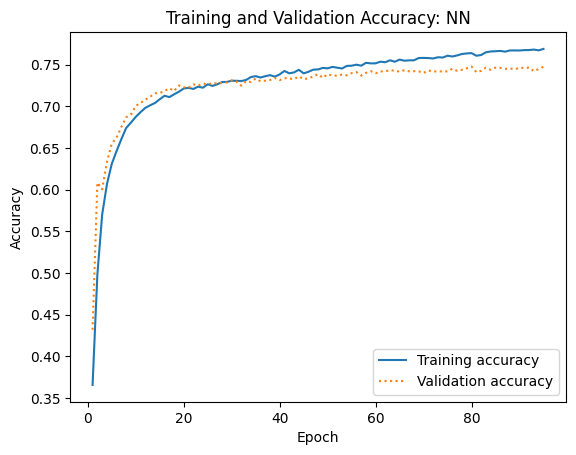

In [50]:
NNmodel.summary()

acc_nn = hist_nn.history['accuracy']
val_nn = hist_nn.history['val_accuracy']
epochs_nn = range(1, len(acc_nn) + 1)

plt.plot(epochs_nn, acc_nn, '-', label='Training accuracy')
plt.plot(epochs_nn, val_nn, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy: NN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [51]:
y_pred_NN_encoded = np.argmax(NNmodel.predict(X_test), axis=1)
y_pred_NN = label_encoder.inverse_transform(y_pred_NN_encoded)

get_accuracy(y_test, y_pred_NN)
mis_NN = get_misclassified_samples(y_test, y_pred_NN)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step
The accuracy is 0.746375
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[1078  326  284  312]
 [ 235 1573  134   58]
 [ 193   73 1697   37]
 [ 279   62   36 1623]]
F1 Score when we treat ELSE as negative: 0.8666393778141629
F1 Score for everclass: 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] 
[0.56961691 0.7798711  0.8176343  0.80545906]


/var/folders/l_/txq0vh11623_5lrnfw_cpmsh0000gn/T/ipykernel_3591/2370515181.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = {'index': misclassified_idx, 'true': y_test[misclassified_idx], 'pred': y_pred[misclassified_idx], 'headline': sampled_test['headline_summary_tokenized'].iloc[misclassified_idx].apply(lambda x: ' '.join(x))}


In [52]:
mis_NN.rename(columns={'index': 'index_NN'}, inplace=True)

misclassified = pd.concat([misclassified, mis_NN['index_NN']], axis=1)

We need to stop early. The usual Neural Network method tends to overfit the training data while the validation accuracy does not change too much.

#### Use the CNN model

In [53]:
# Early stopping
# Creat early stopping callback
early_stopping_cnn = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=10, restore_best_weights=True, min_delta=0.0001, verbose=1)

In [54]:
# Using CNN model (Adding Convolutional and MaxPooling layers)

CNNmodel = keras.models.Sequential()

# Add an additional dimension to the data for the convolutional layer
CNNmodel.add(keras.layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

# Add the convolutional layer
CNNmodel.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add the max pooling layer
CNNmodel.add(keras.layers.MaxPooling1D(pool_size=2))

# Flatten the output
CNNmodel.add(keras.layers.Flatten())

# Add the dense layers
CNNmodel.add(keras.layers.Dense(128, activation='relu'))
CNNmodel.add(keras.layers.Dropout(0.4))
CNNmodel.add(keras.layers.Dense(64, activation='relu'))
CNNmodel.add(keras.layers.Dropout(0.3))
CNNmodel.add(keras.layers.Dense(4, activation='softmax'))

CNNmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

CNNmodel.summary()




/Users/xiaokangwang/Library/Caches/pypoetry/virtualenvs/erdosnewsfinanceproject-fYB74UfD-py3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 200, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 198, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 99, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       405,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,276 (1.58 MB)

 Trainable params: 414,276 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Train the model
hist_cnn = CNNmodel.fit(X_train, y_train_encoded, epochs=200, batch_size=500, validation_split=0.2, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping_cnn])

Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2946 - loss: 1.3798 - val_accuracy: 0.4882 - val_loss: 1.3098
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4450 - loss: 1.2656 - val_accuracy: 0.5249 - val_loss: 1.1194
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5300 - loss: 1.1049 - val_accuracy: 0.5935 - val_loss: 0.9981
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5838 - loss: 1.0031 - val_accuracy: 0.6323 - val_loss: 0.9336
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6183 - loss: 0.9345 - val_accuracy: 0.6456 - val_loss: 0.8853
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6377 - loss: 0.8954 - val_accuracy: 0.6411 - val_loss: 0.8717
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6447 - loss: 0.8730 - val_accuracy: 0.6671 - val_loss: 0.8316
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6660 - loss: 0.8455 - val_accuracy: 0.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 200, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 198, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 99, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3168)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       405,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,242,830 (4.74 MB)

 Trainable params: 414,276 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 828,554 (3.16 MB)

[]

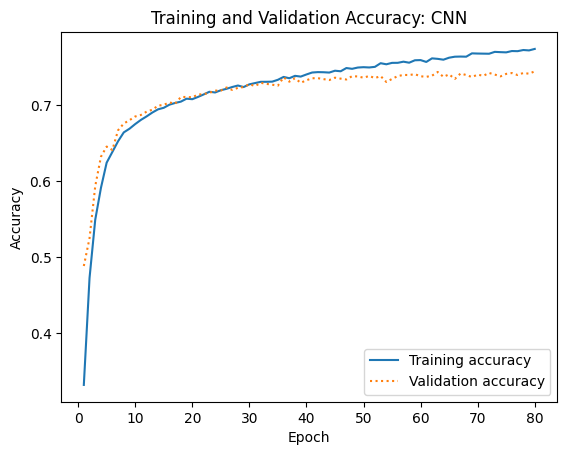

In [56]:
CNNmodel.summary()

acc_cnn = hist_cnn.history['accuracy']
val_cnn = hist_cnn.history['val_accuracy']
epochs_cnn = range(1, len(acc_cnn) + 1)

plt.plot(epochs_cnn, acc_cnn, '-', label='Training accuracy')
plt.plot(epochs_cnn, val_cnn, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy: CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [57]:
y_pred_CNN_encoded = np.argmax(CNNmodel.predict(X_test), axis=1)
y_pred_CNN = label_encoder.inverse_transform(y_pred_CNN_encoded)

get_accuracy(y_test, y_pred_CNN)
mis_CNN = get_misclassified_samples(y_test, y_pred_CNN)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
The accuracy is 0.740375
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[1078  316  275  331]
 [ 276 1499  143   82]
 [ 203   66 1688   43]
 [ 261   47   34 1658]]
F1 Score when we treat ELSE as negative: 0.8635692004596947
F1 Score for everclass: 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] 
[0.56469356 0.76323829 0.81545894 0.8060282 ]


/var/folders/l_/txq0vh11623_5lrnfw_cpmsh0000gn/T/ipykernel_3591/2370515181.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = {'index': misclassified_idx, 'true': y_test[misclassified_idx], 'pred': y_pred[misclassified_idx], 'headline': sampled_test['headline_summary_tokenized'].iloc[misclassified_idx].apply(lambda x: ' '.join(x))}


In [58]:
mis_CNN.rename(columns={'index': 'index_CNN'}, inplace=True)

misclassified = pd.concat([misclassified, mis_CNN['index_CNN']], axis=1)

The common indices of CNN and NN:

In [ ]:
common_indes = np.intersect1d(mis_NN['index'], mis_CNN['index'])

In [ ]:
common_indes
print(f"The common percentage is {len(common_indes)/len(mis_NN)*100}%, and {len(common_indes)/len(mis_CNN)*100}%")

#### Use RNN model (LSTM)

In [ ]:
# Define the early stopping callback
early_stopping_RNN = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=10, restore_best_weights=True, min_delta=0.00001, verbose=1)

In [ ]:
# The RNN model

RNN_model = keras.models.Sequential()

# Add a reshape layer
RNN_model.add(keras.layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

# Add an bidirectional LSTM layer
RNN_model.add(keras.layers.Bidirectional(keras.layers.LSTM(units = 64, return_sequences=True, dropout=0.0, recurrent_dropout=0.0)))

# Add another bidirectional LSTM layer
RNN_model.add(keras.layers.Bidirectional(keras.layers.LSTM(units = 32, return_sequences=False, dropout=0.0, recurrent_dropout=0.0)))

# Add the dense layers
RNN_model.add(keras.layers.Dense(64, activation='relu'))
#RNN_model.add(keras.layers.Dropout(0.4))
#RNN_model.add(keras.layers.Dense(64, activation='relu'))
#RNN_model.add(keras.layers.Dropout(0.3))
# Add the output layer
RNN_model.add(keras.layers.Dense(4, activation='softmax'))

# Compile the model
RNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

RNN_model.summary()

In [ ]:
# Train the model

hist_RNN = RNN_model.fit(X_train, y_train_encoded, epochs=200, batch_size=100, validation_split=0.2, validation_data=(X_test, y_test_encoded), callbacks=[early_stopping_RNN])

In [ ]:
RNN_model.summary()

acc_RNN = hist_RNN.history['accuracy']
val_RNN = hist_RNN.history['val_accuracy']
epochs_RNN = range(1, len(acc_RNN) + 1)

plt.plot(epochs_RNN, acc_RNN, '-', label='Training accuracy')
plt.plot(epochs_RNN, val_RNN, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy: RNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
y_pred_RNN_encoded = np.argmax(RNN_model.predict(X_test), axis=1)
y_pred_RNN = label_encoder.inverse_transform(y_pred_RNN_encoded)

get_accuracy(y_test, y_pred_RNN)
mis_RNN = get_misclassified_samples(y_test, y_pred_RNN)

Maybe instead of using TF-IDF, we can use the word2vec embedding since we do not need to specify the siginificance of each words anymore.

### 9: Ensemble

#### Analyze the misclassified samples

In [59]:
# Return the unclassified samples by any of the model
complete_mask = misclassified.notna().all(axis=1)

unclassified = misclassified[complete_mask]

In [60]:
len(unclassified)

542

In [61]:
unclassified_token = mis_XGB['headline'].loc[complete_mask]
unclassified_token.head()

category        
ELSE      24175     [ ' 1 0 ' ,   ' t o x i c ' ,   ' p e o p l e ...
          57370     [ ' t e l e v i s i o n ' ,   ' a c a d e m y ...
          140885    [ ' f o o d ' ,   ' p o e m ' ,   ' b e s t ' ...
POLITICS  74271     [ ' k i m ' ,   ' d a v i s ' ,   ' l o s e s ...
ELSE      130515    [ ' f e a r ' ,   ' g o i n g ' ,   ' b e t t ...
Name: headline, dtype: object

In [62]:
unclassified_token.iloc[1]

"[ ' t e l e v i s i o n ' ,   ' a c a d e m y ' ,   ' s u e ' ,   ' b l o c k ' ,   ' s a l e ' ,   ' w h i t n e y ' ,   ' h o u s t o n ' ,   ' e m m y ' ,   ' t e l e v i s i o n ' ,   ' a c a d e m y ' ,   ' s u i n g ' ,   ' s t o p ' ,   ' w h i t n e y ' ,   ' h o u s t o n ' ,   ' h e i r ' ,   ' s e l l i n g ' ,   ' e m m y ' ,   ' s t a t u e t t e ' ,   ' s a l e ' ,   ' w o u l d ' ,   ' t a r n i s h ' ]"

The category for this headline is blurred. Even humans cannot get the category correctly.

On the other hand, the `Else` category contains some similar categories to the remaining three. We just brutally threw them away. To refine the classifier, it is important to merge all these simlar categories and then do the classification.

In [63]:
# Analyze the similarity of classification of two models
binary_misclassified = misclassified.notna().astype(int)

binary_misclassified.head()

index_KNN  index_SVM  index_log  index_NB  index_RF  \
ENTERTAINMENT 541            1          0          0         0         1   
ELSE          71019          1          1          1         1         0   
              24175          1          1          1         1         1   
              57370          1          1          1         1         1   
POLITICS      26459          1          1          1         1         1   

                     index_LDA  index_QDA  index_GB  index_XGB  index_NN  \
ENTERTAINMENT 541            0          0         0          0         0   
ELSE          71019          1          1         0          0         1   
              24175          1          1         1          1         1   
              57370          1          1         1          1         1   
POLITICS      26459          1          1         0          0         1   

                     index_CNN  
ENTERTAINMENT 541            0  
ELSE          71019          1  
              24175          1  
              57370          1  
POLITICS      26459          1

In [64]:
# calculate the hamming distance between two models
def hamming_distance(col1, col2):
    differences = sum(a != b for a, b in zip(col1, col2))
    return 1-differences/len(col1)

hamming_similarity_matrix = pd.DataFrame(index=binary_misclassified.columns, columns=binary_misclassified.columns)

for col1 in binary_misclassified.columns:
    for col2 in binary_misclassified.columns:
        hamming_similarity_matrix.loc[col1, col2] = hamming_distance(binary_misclassified[col1], binary_misclassified[col2])

In [65]:
hamming_similarity_matrix

,index_KNN,index_SVM,index_log,index_NB,index_RF,index_LDA,index_QDA,index_GB,index_XGB,index_NN,index_CNN
index_KNN,1.0,0.57578,0.538447,0.613299,0.429421,0.524517,0.44075,0.448366,0.43815,0.487184,0.477526
index_SVM,0.57578,1.0,0.895431,0.761887,0.630386,0.820951,0.656204,0.688336,0.682949,0.77916,0.757244
index_log,0.538447,0.895431,1.0,0.753529,0.656575,0.803306,0.711367,0.71081,0.708767,0.826152,0.789747
index_NB,0.613299,0.761887,0.753529,1.0,0.614413,0.656018,0.656947,0.628529,0.626114,0.707467,0.696694
index_RF,0.429421,0.630386,0.656575,0.614413,1.0,0.625186,0.57448,0.821322,0.822994,0.731612,0.744242
index_LDA,0.524517,0.820951,0.803306,0.656018,0.625186,1.0,0.634287,0.699851,0.681092,0.769502,0.722325
index_QDA,0.44075,0.656204,0.711367,0.656947,0.57448,0.634287,1.0,0.594168,0.596954,0.689822,0.656018
index_GB,0.448366,0.688336,0.71081,0.628529,0.821322,0.699851,0.594168,1.0,0.894688,0.787704,0.793648
index_XGB,0.43815,0.682949,0.708767,0.626114,0.822994,0.681092,0.596954,0.894688,1.0,0.783432,0.78789
index_NN,0.487184,0.77916,0.826152,0.707467,0.731612,0.769502,0.689822,0.787704,0.783432,1.0,0.864413


Now the precision:

- KNN: 54%
- SVM: 70%
- LOG: 70%
- NB: 64%
- RF: 74%
- LDA: 69%
- QDA: 63%
- GB: 77%
- XGB: 77%
- NN: 74%
- CNN: 74%

Based on these information, we should try to use models where the hamming distance is small and itself the precision is high.

So we choose: Logistic, RandomForest, XGB, CNN for a voting classifier.

#### Building a Voting classifier

Since we have different classifiers using different shape of data and API, we will make a customized classifier

In [66]:

class customized_voting_classifier:
    def __init__(self, X_train):
        self.log = LogisticRegression(C=1000, solver='newton-cg')
        self.rf = RandomForestClassifier(n_estimators=700, max_depth=200)
        self.xgb = XGBClassifier(learning_rate=0.1, max_depth = 10, n_estimators = 500)
        self.cnn = keras.models.Sequential()
        # Add an additional dimension to the data for the convolutional layer
        self.cnn.add(keras.layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

        # Add the convolutional layer
        self.cnn.add(keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))

        # Add the max pooling layer
        self.cnn.add(keras.layers.MaxPooling1D(pool_size=2))

        # Flatten the output
        self.cnn.add(keras.layers.Flatten())

        # Add the dense layers
        self.cnn.add(keras.layers.Dense(128, activation='relu'))
        self.cnn.add(keras.layers.Dropout(0.4))
        self.cnn.add(keras.layers.Dense(64, activation='relu'))
        self.cnn.add(keras.layers.Dropout(0.3))
        self.cnn.add(keras.layers.Dense(4, activation='softmax'))

        self.cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Lable encoder
        self.label_encoder = LabelEncoder()

    def fit(self, X_train, y_train):
        print("Start to train the models: Logistic")
        self.log.fit(X_train, y_train)
        print("Logistic Regression has been trained")
        print("Start to train the models: Random Forest")
        self.rf.fit(X_train, y_train)
        print("Random Forest has been trained")
        # Encode the labels
        y_train_encoded = self.label_encoder.fit_transform(y_train)
        

        # One-hot encode the labels
        y_train_encoded_cnn = keras.utils.to_categorical(y_train_encoded, num_classes=4)
       
        print("Start to train the models: XGBoost")
        self.xgb.fit(X_train, y_train_encoded)
        print("XGBoost has been trained")
        # Early stopping
        print("Start to train the models: CNN")
        early_stopping_cnn = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=10, restore_best_weights=True, min_delta=0.0001, verbose=1)
        self.cnn.fit(X_train, y_train_encoded_cnn, epochs=200, batch_size=500, validation_split=0.2, callbacks=[early_stopping_cnn], verbose=1)
        print("CNN has been trained")

    def predict(self, X_test, arg = "soft", weights = [0.1, 0.2, 0.4, 0.3]):
        # print(f"The accuracy for Logistic Regression is {accuracy_score(y_test, self.log.predict(X_test))}")
        # print(f"The accuracy for Random Forest is {accuracy_score(y_test, self.rf.predict(X_test))}")
        # print(f"The accuracy for XGBoost is {accuracy_score(y_test, self.label_encoder.inverse_transform(self.xgb.predict(X_test)))}")
        # print(f"The accuracy for CNN is {accuracy_score(y_test, self.label_encoder.inverse_transform(np.argmax(self.cnn.predict(X_test), axis=1)))}")
        ##############################
        if arg == "soft":
            log_prob = self.log.predict_proba(X_test)
            rf_prob = self.rf.predict_proba(X_test)
            xgb_prob = self.xgb.predict_proba(X_test)
            cnn_prob = self.cnn.predict(X_test)

            weight = weights

            average_prob = log_prob*weight[0] + rf_prob*weight[1] + xgb_prob*weight[2] + cnn_prob*weight[3]

            y_pred = self.label_encoder.inverse_transform(np.argmax(average_prob, axis=1))
        elif arg == "hard":
            log_pred = self.log.predict(X_test)
            rf_pred = self.rf.predict(X_test)
            xgb_pred = self.label_encoder.inverse_transform(self.xgb.predict(X_test))
            cnn_pred = self.label_encoder.inverse_transform(np.argmax(self.cnn.predict(X_test), axis=1))

            y_pred = []
            for i in range(len(X_test)):
                pred = [log_pred[i], rf_pred[i], xgb_pred[i], cnn_pred[i]]
                y_pred.append(max(set(pred), key = pred.count))
            y_pred = pd.Series(y_pred)
            y_pred.index = y_test.index

        else:
            print("The arg should be either soft or hard")
            y_pred = None

        
        return y_pred

        

        

In [67]:
voting = customized_voting_classifier(X_train)
voting.fit(X_train, y_train)

/Users/xiaokangwang/Library/Caches/pypoetry/virtualenvs/erdosnewsfinanceproject-fYB74UfD-py3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Start to train the models: Logistic
Logistic Regression has been trained
Start to train the models: Random Forest
Random Forest has been trained
Start to train the models: XGBoost
XGBoost has been trained
Start to train the models: CNN
Epoch 1/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2708 - loss: 1.3839 - val_accuracy: 0.4613 - val_loss: 1.3566
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3940 - loss: 1.3285 - val_accuracy: 0.5255 - val_loss: 1.1972
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4953 - loss: 1.1783 - val_accuracy: 0.5478 - val_loss: 1.0823
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5406 - loss: 1.0781 - val_accuracy: 0.5892 - val_loss: 1.0058
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5797 - loss: 1.0073 - val_accuracy: 0.6225 - val_loss: 0.9509
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6049 - loss: 0.9579 - val_accuracy: 0.6420 - val_loss: 0.9

In [68]:
voting_pred = voting.predict(X_test, arg="hard")
get_accuracy(y_test, voting_pred)
mis_voting_hard = get_misclassified_samples(y_test, voting_pred)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step
The accuracy is 0.763875
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[1034  292  273  401]
 [ 201 1572  148   79]
 [ 157   46 1744   53]
 [ 175   41   23 1761]]
F1 Score when we treat ELSE as negative: 0.8794337649802944
F1 Score for everclass: 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] 
[0.5797589  0.79574791 0.83285578 0.82021425]


/var/folders/l_/txq0vh11623_5lrnfw_cpmsh0000gn/T/ipykernel_3591/2370515181.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = {'index': misclassified_idx, 'true': y_test[misclassified_idx], 'pred': y_pred[misclassified_idx], 'headline': sampled_test['headline_summary_tokenized'].iloc[misclassified_idx].apply(lambda x: ' '.join(x))}


In [69]:
# Initialize variables to track best weights and accuracy
best_acc = 0
best_weights = None
acc_voting = []

# Iterate over possible weights
for i in np.arange(0, 1.1, 0.1):
    for j in np.arange(0, 1.1 - i, 0.1):
        for k in np.arange(0, 1.1 - i - j, 0.1):
            weights = [i, j, k, 1 - i - j - k]
            voting_pred = voting.predict(X_test, arg="soft", weights=weights)
            acc = accuracy_score(y_test, voting_pred)
            acc_voting.append((acc, weights))
            
            # Update best weights if current accuracy is higher
            if acc > best_acc:
                best_acc = acc
                best_weights = weights

# Get the maximum accuracy and corresponding weights
max_acc, max_weights = max(acc_voting, key=lambda x: x[0])

print(f"Maximum accuracy: {max_acc}")
print(f"Best weights: {max_weights}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step
250/250 ━━━

In [70]:
voting_pred = voting.predict(X_test, arg="soft", weights=[0.2, 0.3, 0.5, 0.0])
get_accuracy(y_test, voting_pred)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
The accuracy is 0.77675
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[1177  271  221  331]
 [ 199 1641  107   53]
 [ 200   70 1698   32]
 [ 224   46   32 1698]]
F1 Score when we treat ELSE as negative: 0.8814754098360655
F1 Score for everclass: 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] 
[0.61947368 0.81479643 0.83686545 0.82547399]


Note that hard voting sometimes is not good enough. We prefer using the soft with a slightly change of weights.

In [71]:
voting_pred = voting.predict(X_test, arg="soft", weights=[0.2, 0.2, 0.4, 0.2])
get_accuracy(y_test, voting_pred)
mis_voting_soft = get_misclassified_samples(y_test, voting_pred)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
The accuracy is 0.776625
The confusion matrix 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] is 
[[1163  284  232  321]
 [ 201 1630  113   56]
 [ 195   57 1712   36]
 [ 228   39   25 1708]]
F1 Score when we treat ELSE as negative: 0.880373372635716
F1 Score for everclass: 
['ELSE', 'ENTERTAINMENT', 'POLITICS', 'WELLNESS'] 
[0.6142065  0.81296758 0.83880451 0.82892502]


/var/folders/l_/txq0vh11623_5lrnfw_cpmsh0000gn/T/ipykernel_3591/2370515181.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = {'index': misclassified_idx, 'true': y_test[misclassified_idx], 'pred': y_pred[misclassified_idx], 'headline': sampled_test['headline_summary_tokenized'].iloc[misclassified_idx].apply(lambda x: ' '.join(x))}


In [79]:
# Save the fitted model
votting_model_path = os.path.join(config['info']['local_data_path'], 'model_news', config['news_model']['input']['classification_headlines'])
joblib.dump(voting, votting_model_path)

['/Users/xiaokangwang/Documents/PycharmProjects/Projects for Erdos 2024 fall/data_set/model_news/classification_headline.joblib']

It is good enough to seperate the lables except 'ELSE'. And this is beacuse our choice of 'ELSE' is quite arbitary, the f1 score of this class is relatively low.

## Use the model to predict the ALL_news dataset

In [72]:
# Load the political data
political_path = os.path.join(config['info']['local_data_path'], 'data_clean', config['news_preprocessing']['output']['all_news_politic_cleaned_file'])
political = pd.read_csv(political_path)

In [73]:
political.head()

,date,title,section,publication,summary,token,word_count
0,2017-04-07 00:00:00,U.S. lawmakers ask for disclosure of number of...,Politics,Reuters,WASHINGTON (Reuters) - A U.S. congressional co...,"['washington', 'reuters', 'congressional', 'co...",402
1,2017-10-16 00:00:00,Trump keeping options open as Republican feud ...,Politics,Reuters,WASHINGTON (Reuters) - Like the deal-maker he ...,"['washington', 'reuters', 'like', 'say', 'pres...",575
2,2019-01-18 00:00:00,Trump tells anti-abortion marchers he will sup...,Politics,Reuters,WASHINGTON (Reuters) - U.S. President Donald T...,"['washington', 'reuters', 'president', 'donald...",421
3,2016-07-21 00:00:00,Exclusive: Trump considering fracking mogul Ha...,Politics,Reuters,CLEVELAND (Reuters) - Republican presidential ...,"['cleveland', 'reuters', 'republican', 'presid...",610
4,2017-10-06 00:00:00,White House chief of staff's personal cellphon...,Politics,Reuters,WASHINGTON (Reuters) - White House officials b...,"['washington', 'reuters', 'white', 'house', 'o...",174


In [74]:
# Leave only the first 100 tokens
political_headlines = political['token'].apply(lambda x: x.split()[2:102])

In [75]:
political_headlines.head()

0    ['congressional',, 'committee',, 'friday',, 'a...
1    ['like',, 'say',, 'president',, 'donald',, 'tr...
2    ['president',, 'donald',, 'trump',, 'spoke',, ...
3    ['republican',, 'presidential',, 'candidate',,...
4    ['white',, 'house',, 'official',, 'believe',, ...
Name: token, dtype: object

In [76]:
# use the tfidf vectorizer to transform the data
political_headlines_joined = political_headlines.apply(lambda x: ' '.join(x))
political_tfidf = nmf.transform(tfidf.transform(political_headlines_joined))

In [77]:
pred = voting.predict(political_tfidf, arg="soft", weights=[0.2, 0.2, 0.4, 0.2])

910/910 ━━━━━━━━━━━━━━━━━━━━ 1s 572us/step


In [78]:
pd.Series(pred).describe()
print(f"The percentage of the true politic detection is {pd.Series(pred).value_counts(normalize=True)['POLITICS']*100}%")

The percentage of the true politic detection is 96.7513493072983%


It works!